# **Image Encryption using Genetic Algorithm**

## **Importing the Required Libraries**

In [21]:
import numpy as np
import cv2
from google.colab import files
import random
import matplotlib.pyplot as plt
from Crypto.Cipher import AES, DES
from Crypto.Util.Padding import pad, unpad
import os

## **Function to Load the Image**

In [22]:
# --- Helper Functions ---
def load_image():
    """Upload and load the image."""
    print("Upload an image:")
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Failed to load the image. Please upload a valid grayscale image.")
    print(f"Loaded image shape: {img.shape}")
    return img

## **Function to Generate Population**

In [23]:
def generate_population(img, population_size=20):
    """Generate a diverse population of images (chromosomes)."""
    population = []
    for _ in range(population_size):
        mutation = np.random.randint(0, 256, img.shape, dtype=np.uint8)
        mutated_img = cv2.bitwise_xor(img, mutation)
        population.append(mutated_img)
    return population

### **Generate Population**

* Creates a population of diverse images (chromosomes) by applying random
mutations to the original image.

* Each individual in the population is generated by performing an XOR operation between the original image and a random mutation matrix.

* The function returns a list of mutated images as the population for the genetic algorithm.

## **Functions for Mutation and Tounament Selection**

In [24]:
def mutate(image, mutation_rate):
    """Mutate an image based on the mutation rate."""
    mask = np.random.rand(*image.shape) < mutation_rate
    mutation = np.random.randint(0, 256, image.shape, dtype=np.uint8)
    return cv2.bitwise_xor(image, mutation * mask)

def tournament_selection(population, size=3):
    """Tournament selection to choose parents."""
    actual_size = min(size, len(population))
    candidates = random.sample(population, actual_size)
    return max(candidates, key=lambda img: np.random.random())  # Random fitness for demonstration

### **Mutate Function:**

Introduces random changes to the image by selecting pixels based on the mutation rate and applying a random mutation, altering pixel values using XOR.

### **Tournament Selection:**

Selects two parent images from a population by randomly sampling candidates and choosing the one with the highest "fitness" (randomly simulated for demonstration purposes).


## **Functions for Crossover and Genetic Algorithm**

In [25]:
def crossover(parent1, parent2):
    """Perform crossover with XOR and weighted blending."""
    offspring_xor = cv2.bitwise_xor(parent1, parent2)
    alpha = 0.5  # Weight factor for blending
    offspring_blend = cv2.addWeighted(parent1, alpha, parent2, 1 - alpha, 0)
    offspring = cv2.bitwise_xor(offspring_xor, offspring_blend.astype(np.uint8))
    return offspring

def genetic_algorithm(img, layer_configs):
    """Apply Genetic Algorithm for image encryption across layers."""
    population = generate_population(img, population_size=20)
    for layer, (generations, mutation_rate) in enumerate(layer_configs):
        for generation in range(generations):
            new_population = []
            while len(new_population) < len(population):  # Ensure full population size
                parent1 = tournament_selection(population, size=3)
                parent2 = tournament_selection(population, size=3)
                offspring = crossover(parent1, parent2)
                offspring = mutate(offspring, mutation_rate)
                new_population.append(offspring)
            population = new_population

    return population[0]  # Return the first chromosome as the encrypted image

### **Crossover Function**:
The crossover function performs a crossover between two parent images using XOR
and weighted blending techniques to create offspring.

### **Genetic Algorithm Function:**

Applies a genetic algorithm to an image across multiple layers, evolving a population of images over generations with selection, crossover, and mutation.


## **Functions for AES & DES Encryption**

In [26]:
def aes_encrypt_decrypt(image, key, mode="encrypt"):
    """Encrypt or decrypt the image using AES."""
    cipher = AES.new(key, AES.MODE_ECB)
    if mode == "encrypt":
        padded_data = pad(image.tobytes(), AES.block_size)
        encrypted = cipher.encrypt(padded_data)
        encrypted_image = np.frombuffer(encrypted, dtype=np.uint8)
        encrypted_image = encrypted_image[:image.size].reshape(image.shape)
        return encrypted_image
    elif mode == "decrypt":
        decrypted = unpad(cipher.decrypt(image), AES.block_size)
        decrypted_image = np.frombuffer(decrypted, dtype=np.uint8).reshape(image.shape)
        return decrypted_image

def des_encrypt_decrypt(image, key, mode="encrypt"):
    """Encrypt or decrypt the image using DES."""
    cipher = DES.new(key, DES.MODE_ECB)
    if mode == "encrypt":
        padded_data = pad(image.tobytes(), DES.block_size)
        encrypted = cipher.encrypt(padded_data)
        encrypted_image = np.frombuffer(encrypted, dtype=np.uint8)
        encrypted_image = encrypted_image[:image.size].reshape(image.shape)
        return encrypted_image
    elif mode == "decrypt":
        decrypted = unpad(cipher.decrypt(image), DES.block_size)
        decrypted_image = np.frombuffer(decrypted, dtype=np.uint8).reshape(image.shape)
        return decrypted_image

## **Functions for Entropy, Correlation, and NCPR**

In [27]:
def reshape_for_display(data, width=200):
    """Reshape a 1D array for visualization as an image."""
    height = len(data) // width
    reshaped_data = data[:height * width].reshape((height, width))
    return reshaped_data

def entropy(image):
    """Calculate the entropy of an image."""
    # Flatten the image and calculate the histogram
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])

    # Normalize the histogram
    hist = hist / hist.sum()

    # Calculate entropy
    entropy_value = -np.sum(hist * np.log2(hist + np.finfo(float).eps))  # Add epsilon to avoid log(0)
    return entropy_value

def correlation(image1, image2):
    """Calculate the correlation between two images."""
    return np.corrcoef(image1.flatten(), image2.flatten())[0, 1]

def npcr(image1, image2):
    """Calculate the Number of Pixels Change Rate (NPCR) between two images."""
    diff = np.count_nonzero(image1 != image2)
    return (diff / image1.size) * 100

### **Reshape for Display:**

* Reshapes a 1D array into a 2D array to allow visualization as an image, with a specified width.
* The height is computed based on the length of the data and the provided width.
Returns the reshaped data as a 2D array for display.

### **Entropy:**

* Calculates the entropy of an image, measuring the amount of information or randomness in it.
* First, the image is flattened and a histogram is created to capture pixel intensity distributions.
* The entropy is calculated as the negative sum of the normalized histogram times the log of the histogram values, with a small epsilon to avoid log(0).

### **Correlation:**

* Computes the correlation between two images by comparing their pixel intensities.
* Flattens both images into 1D arrays and calculates the correlation coefficient using np.corrcoef.
* Returns the correlation value that quantifies the similarity between the two images.

### **NPCR:**

* Calculates the Number of Pixels Change Rate (NPCR) to measure the difference between two images.
* Counts the number of pixels that differ between the two images and computes the percentage of changed pixels.
* Returns the NPCR as a percentage indicating the level of change.

## **Function to Plot Histogram**

In [28]:
def plot_histogram(image, name="Image"):
    """Plot the histogram of pixel intensities for the image."""
    plt.figure(figsize=(8, 6))
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
    plt.title(f"Histogram of {name}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

## **Main Function**

Upload an image:


Saving will_smith.webp to will_smith (15).webp
Loaded image shape: (155, 226)
Applying Genetic Algorithm...
Applying AES Encryption...
Applying DES Encryption...
Calculating Metrics...
Entropy - Original: 7.2079, AES: 7.9945, DES: 7.9841, GA: 7.8369
Correlation - AES: -0.0005, DES: 0.0098, GA: -0.0024
NPCR - AES: 99.6375, DES: 99.6860, GA: 99.5233
Comparing encryption methods...


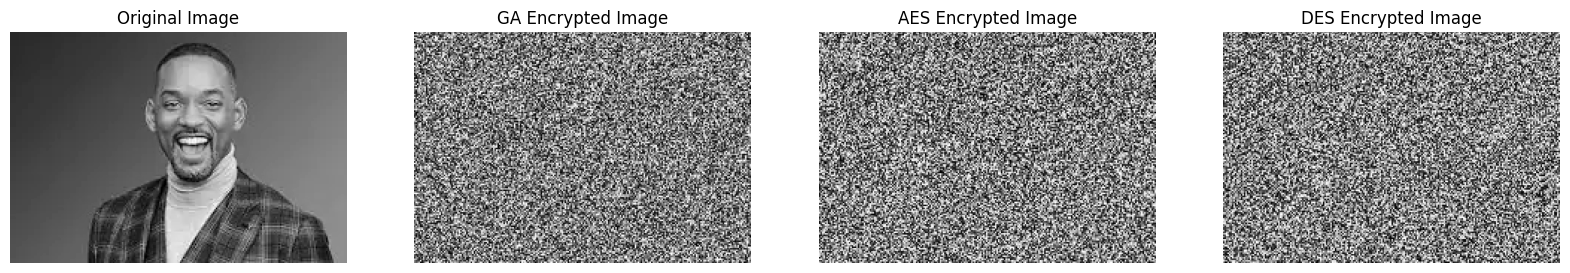

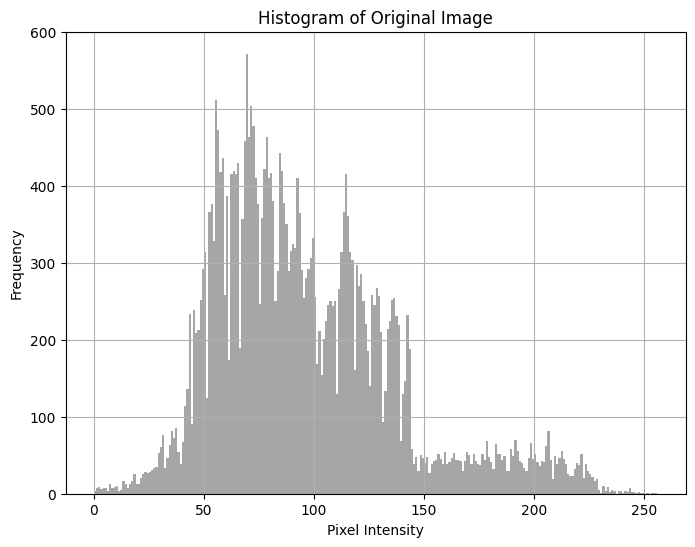

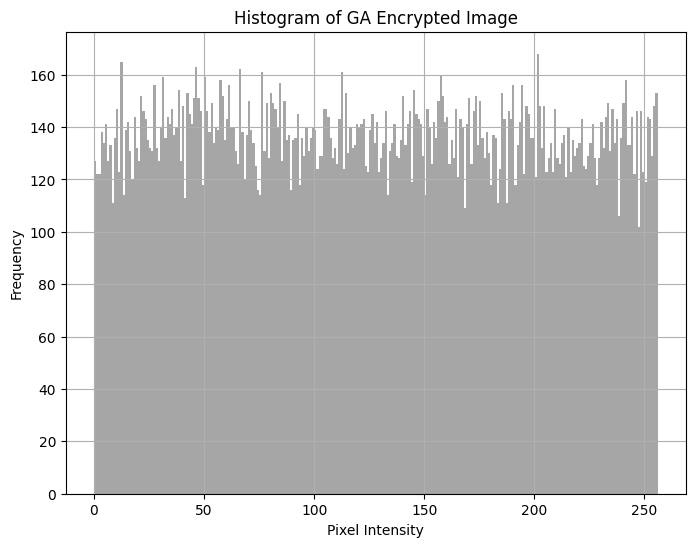

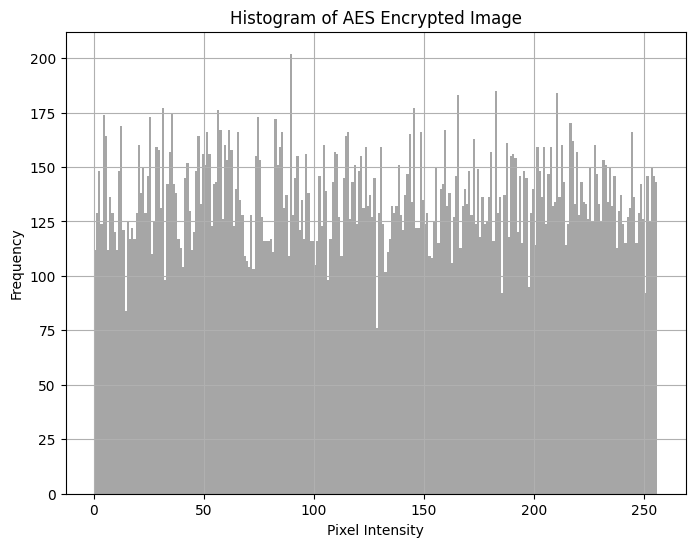

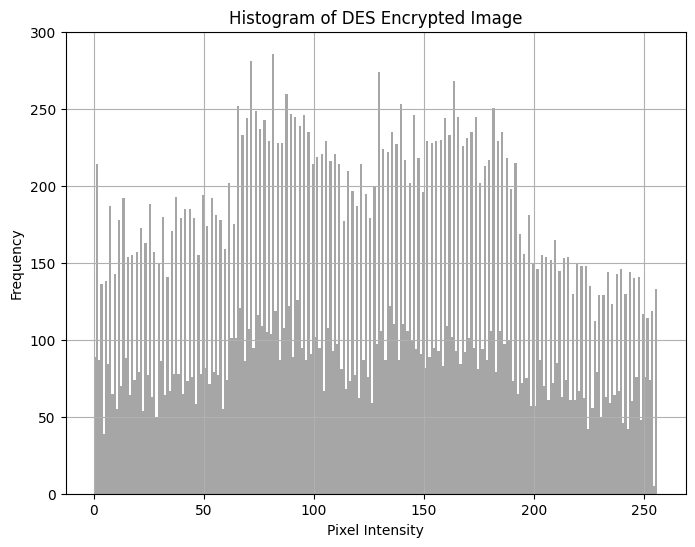

In [29]:
def main():
    # Step 1: Load the image
    img = load_image()

    # Step 2: Apply Genetic Algorithm encryption
    layer_configs = [(30, 0.05), (45, 0.03), (60, 0.02)]  # (generations, mutation_rate) for each layer
    print("Applying Genetic Algorithm...")
    ga_encrypted_img = genetic_algorithm(img, layer_configs)

    # Step 3: Apply AES encryption
    print("Applying AES Encryption...")
    aes_key = os.urandom(16)  # AES key (16 bytes)
    aes_encrypted_img = aes_encrypt_decrypt(img, aes_key, mode="encrypt")

    # Step 4: Apply DES encryption
    print("Applying DES Encryption...")
    des_key = os.urandom(8)  # DES key (8 bytes)
    des_encrypted_img = des_encrypt_decrypt(img, des_key, mode="encrypt")

    # Step 5: Resize all encrypted images to match the original
    # (For AES and DES encrypted images, we handled reshaping above)
    ga_encrypted_img = cv2.resize(ga_encrypted_img, img.shape[::-1])

    # Step 6: Calculate Metrics
    print("Calculating Metrics...")

    # Entropy
    entropy_original = entropy(img)
    entropy_aes = entropy(aes_encrypted_img)
    entropy_des = entropy(des_encrypted_img)
    entropy_ga = entropy(ga_encrypted_img)

    # Correlation
    correlation_aes = correlation(img, aes_encrypted_img)
    correlation_des = correlation(img, des_encrypted_img)
    correlation_ga = correlation(img, ga_encrypted_img)

    # NPCR
    npcr_aes = npcr(img, aes_encrypted_img)
    npcr_des = npcr(img, des_encrypted_img)
    npcr_ga = npcr(img, ga_encrypted_img)

    # Display Metrics
    print(f"Entropy - Original: {entropy_original:.4f}, AES: {entropy_aes:.4f}, DES: {entropy_des:.4f}, GA: {entropy_ga:.4f}")
    print(f"Correlation - AES: {correlation_aes:.4f}, DES: {correlation_des:.4f}, GA: {correlation_ga:.4f}")
    print(f"NPCR - AES: {npcr_aes:.4f}, DES: {npcr_des:.4f}, GA: {npcr_ga:.4f}")

    # Step 7: Compare the encrypted images
    print("Comparing encryption methods...")

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(ga_encrypted_img, cmap='gray')
    axes[1].set_title("GA Encrypted Image")
    axes[2].imshow(aes_encrypted_img, cmap='gray')
    axes[2].set_title("AES Encrypted Image")
    axes[3].imshow(des_encrypted_img, cmap='gray')
    axes[3].set_title("DES Encrypted Image")
    for ax in axes:
        ax.axis("off")
    plt.show()

    plot_histogram(img, "Original Image")
    plot_histogram(aes_encrypted_img, "GA Encrypted Image")
    plot_histogram(des_encrypted_img, "AES Encrypted Image")
    plot_histogram(ga_encrypted_img, "DES Encrypted Image")

# Run the main function
if __name__ == "__main__":
    main()
